In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler

In [30]:
df_migrations = pd.read_csv("Data project_ntds/countyinflow1516.csv" )


# create the combined fips county number of destination
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-destination'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# create the combined fips county number of source
df_migrations['statefips_str1'] = df_migrations['y1_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str1'] = df_migrations['y1_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips-source'] = df_migrations['statefips_str1'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str1']

# Experimenting with parametres(not important)
#new_df = df[(df['WindSpeed']>4) & (df['Temperature']>30)]
#df_migrations2 = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
#df_migrations3 = df_migrations[(df_migrations['y1_statefips']== 96) & (df_migrations['y2_countyfips']!= 0)]

#Cleaning the data to have only source and origin counties and unemployment rate as a new column
df_migrations = df_migrations[df_migrations['y1_statefips']<=56]
df_migrations["Unemployment rate"] = df_migrations["n1"]/(df_migrations["n2"] +df_migrations["n1"] )
df_migrations1 = df_migrations[df_migrations['combined_fips-destination'] ==df_migrations['combined_fips-source']]  # keeping Unemployment rate of non migrants
  


 #drop useless information 
df_migrations = df_migrations.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])
df_migrations1 = df_migrations1.drop(columns=["y1_countyname","y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str","statefips_str1", "countyfips_str1"])
df_migrations1 =df_migrations1.drop(columns=["agi","combined_fips-source"])



# remove nodes where data is undefined undefined data by zero
df_migrations = df_migrations[df_migrations['n1'] != -1]
df_migrations1 = df_migrations1[df_migrations1['n1'] != -1]
df_migrations3 = df_migrations3[df_migrations3['n1'] != -1]

# convert combined fips to int64
df_migrations['combined_fips-destination'] = df_migrations['combined_fips-destination'].astype('int64')
df_migrations['combined_fips-source'] = df_migrations['combined_fips-source'].astype('int64')
df_migrations1['combined_fips-destination'] = df_migrations1['combined_fips-destination'].astype('int64')

print(df_migrations1)
df_migrations1= df_migrations1.drop(columns=["n1","n2","combined_fips-destination"])

#extracting the combined fips destination and combined fips source for graph in form of numpy arrays
df_graph= df_migrations.drop(columns=["n1","n2","agi","Unemployment rate"])

arr = df_graph.to_numpy()



          n1      n2  combined_fips-destination  Unemployment rate
10     17914   41255                       1001           0.302760
31     69838  151110                       1003           0.316083
81      7505   16675                       1005           0.310380
98      6227   14522                       1007           0.300111
115    17196   41386                       1009           0.293537
...      ...     ...                        ...                ...
86255  16060   36990                      56037           0.302733
86278  10773   21886                      56039           0.329863
86294   7195   17699                      56041           0.289025
86310   3041    6772                      56043           0.309895
86322   2614    5608                      56045           0.317928

[3141 rows x 4 columns]


In [12]:
df_presidential_result = pd.read_csv("Data project_ntds/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

#Sorting according to the fips code to be consistent with the migration data by IRS
df_presidential_result = df_presidential_result.sort_values(by=['combined_fips'])

#Adding a new column of the winners with -1 corresponding to democrat and 1 to republican

df_presidential_result["Winner"] =  np.where((df_presidential_result['per_dem'] > df_presidential_result['per_gop'])
                     , -1, 1)

print(df_presidential_result)
df_presidential_result = df_presidential_result.drop(columns=["per_dem","per_gop","combined_fips"])


       per_dem   per_gop  combined_fips  Winner
29    0.239569  0.734358           1001       1
30    0.195653  0.773515           1003       1
31    0.466603  0.522714           1005       1
32    0.214220  0.769662           1007       1
33    0.084699  0.898519           1009       1
...        ...       ...            ...     ...
3136  0.194046  0.729428          56037       1
3137  0.600608  0.321945          56039      -1
3138  0.149261  0.764187          56041       1
3139  0.143203  0.783580          56043       1
3140  0.088182  0.869226          56045       1

[3141 rows x 4 columns]


In [10]:
possible_nodes = np.unique(arr)
print(possible_nodes)
A_migr = np.zeros((len(possible_nodes), len(possible_nodes))) 

for dest, source in arr : 
     
    i = np.where(possible_nodes == dest)
    #print(i)
    j = np.where(possible_nodes == source)
    #print(j)
    A_migr[j[0], i[0]] = 1
 

#Creating a dictionary of attribute of Unemployment rate
z = df_migrations1.to_numpy()
d = dict(enumerate(z.flatten(), 0))


#Creating a dictionary of attribute of county election result
z2 = df_presidential_result.to_numpy()
d2 = dict(enumerate(z.flatten(), 0))


[ 1001  1003  1005 ... 56041 56043 56045]


In [9]:
G_migr = nx.from_numpy_matrix(A_migr,create_using = nx.DiGraph())

nx.set_node_attributes(G_migr,d,"Unemployment rate")
nx.set_node_attributes(G_migr,d2,"Winner")
print('Number of nodes: {}, Number of edges: {}'. format(G_migr.number_of_nodes(), G_migr.number_of_edges()))

#print(' Number of connected components: {}'. format( nx.number_connected_components(G_migr)))
nx.write_gexf(G_migr, "county_graph.gexf")

print(f"The average clustering coefficient is: {nx.average_clustering(G_migr)}")
 
#for i in range(3140):
 #   print (G_migr.nodes[i])
#G_migr.nodes[2001]

Number of nodes: 3141, Number of edges: 50030
The average clustering coefficient is: 0.47991882266324526


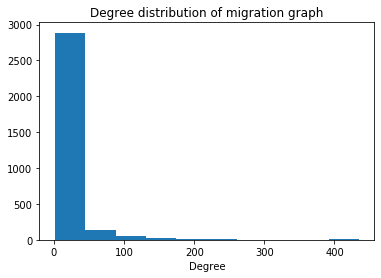

In [6]:
migr_citation = A_migr.sum(1)
migr_hist_normalization = np.ones(migr_citation.shape[0]) / migr_citation.shape[0]
plt.hist(migr_citation,bins = 10);
plt.gca().set(title='Degree distribution of migration graph', xlabel='Degree');